# Trying to close wmt budget

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import gcsfs
import gcm_filters
import xgcm
from xhistogram.xarray import histogram
from typing import Annotated

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [3]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
tendencies = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tendencies_outliers_rm.zarr'))
rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))


In [5]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [5]:
res = tendencies.rho_lap + tendencies.cabbeling - tendencies.sss - tendencies.sst

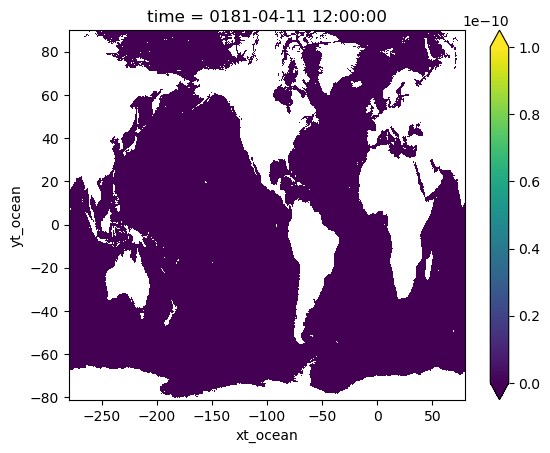

In [6]:
res.isel(time=100).plot(robust=True, vmin=1e-10);

## Run histogram and check residual

In [6]:
delta_rho = 0.1
rho = rho.rho_test
rho_bins = np.arange(1015, 1035, delta_rho)
avg_mld = ds.mld.mean('time').compute()
weights = coord.area_t*avg_mld

In [7]:
def global_hist_func(ds, variable):
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                    weights=(ds[variable].fillna(0.)*weights.fillna(0.)),
                    dim=['xt_ocean', 'yt_ocean']) / delta_rho
    return hist

In [8]:
all_tendencies = list(tendencies.data_vars)

In [9]:
global_hists = xr.merge([global_hist_func(tendencies, var).rename('OMEGA_' + var) for var in all_tendencies])

In [10]:
global_hists

<xarray.Dataset>
Dimensions:          (time: 7305, rho0_bin: 199)
Coordinates:
  * time             (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
Data variables:
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

In [11]:
residual = global_hists.OMEGA_rho_lap + global_hists.OMEGA_cabbeling - global_hists.OMEGA_sss - global_hists.OMEGA_sst

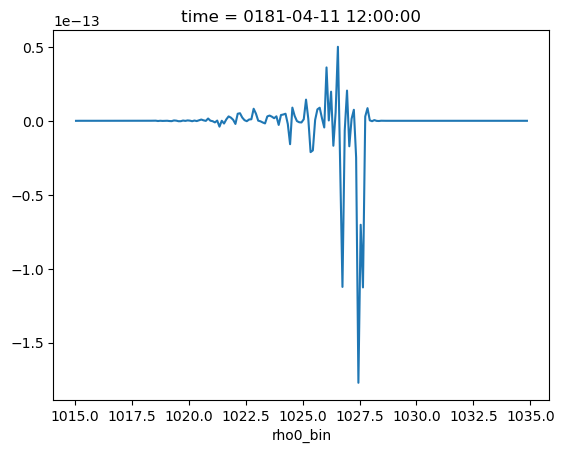

In [12]:
(residual/1e6).isel(time=100).plot()

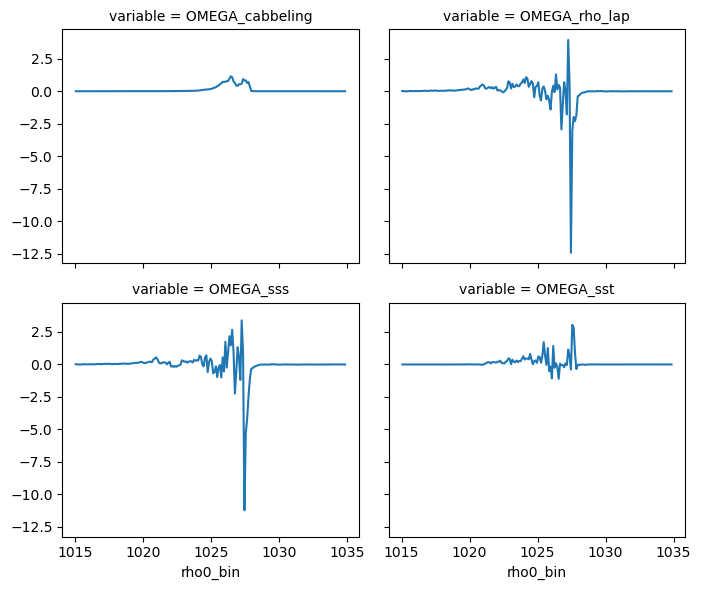

In [13]:
(global_hists.isel(time=100)/1e6).to_array().plot(col='variable', col_wrap=2);

# Mask by basin

In [6]:
!pip install git+https://github.com/mathause/regionmask.git

  Cloning https://github.com/mathause/regionmask.git to /tmp/pip-req-build-4mhmqmil
  Running command git clone --filter=blob:none --quiet https://github.com/mathause/regionmask.git /tmp/pip-req-build-4mhmqmil
  Resolved https://github.com/mathause/regionmask.git to commit 29339a123960bc2006d0dc28ada56c885489c6ff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for regionmask: filename=regionmask-0.9.0.post1.dev63+g29339a1-py3-none-any.whl size=69868 sha256=8f84c284aaf42eb621ea72ba2d1d482a73e52abd9970b785a2d04d04d3e0576c
  Stored in directory: /tmp/pip-ephem-wheel-cache-scxvi_uh/wheels/1a/62/0f/f392f37f9bd2d2d61b9a6b63de17bb421b3f7c2972b03c9934
Successfully built regionmask


In [7]:
!pip install git+https://github.com/jbusecke/xmip.git

  Cloning https://github.com/jbusecke/xmip.git to /tmp/pip-req-build-xsg1r_fi
  Running command git clone --filter=blob:none --quiet https://github.com/jbusecke/xmip.git /tmp/pip-req-build-xsg1r_fi
  Resolved https://github.com/jbusecke/xmip.git to commit 29d9e5fc4f3396ef2473f74bacda5fb279c444f4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached xgcm-0.6.1-py3-none-any.whl (60 kB)
  Created wheel for xmip: filename=xmip-0.7.2.dev13+g29d9e5f-py3-none-any.whl size=58767 sha256=95dbd7702c4c95dde2c16e24512ca965e19adc8df678eea7d8896a6b1b128dcf
  Stored in directory: /tmp/pip-ephem-wheel-cache-0poc1k3e/wheels/14/81/1d/2382ef5c4df3bc79c5b5a3c37400af047e5a775a4b2cf79b42
Successfully built xmip
  Attempting uninstall: xgcm
    Found existing installation: xgcm 0.8.1
    Uninstalling xgcm-0.8.1:
      Successfully uninstalled xgcm-0.8.1
  Attempting uninstall: xmip
    Found existing installation: 

In [8]:
import regionmask  
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask

<GeoAxes: >

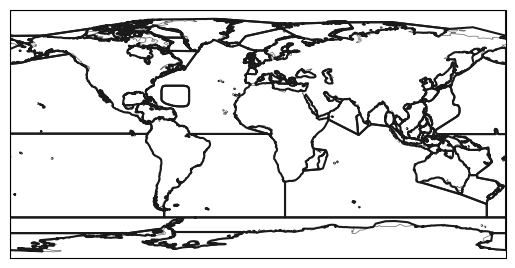

In [9]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)

In [10]:
da = ds.temp.isel(time=0, st_ocean=0).squeeze()

In [11]:
da_renamed = da.rename({'geolat_t':'lat', 'geolon_t':'lon'}).drop(('xt_ocean', 'yt_ocean')).load()

In [12]:
mask = merged_mask(basins, da_renamed)

/srv/conda/envs/notebook/lib/python3.10/site-packages/regionmask/core/mask.py:175: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/pygeos/io.py:523: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [18]:
mask_ds = mask.to_dataset()

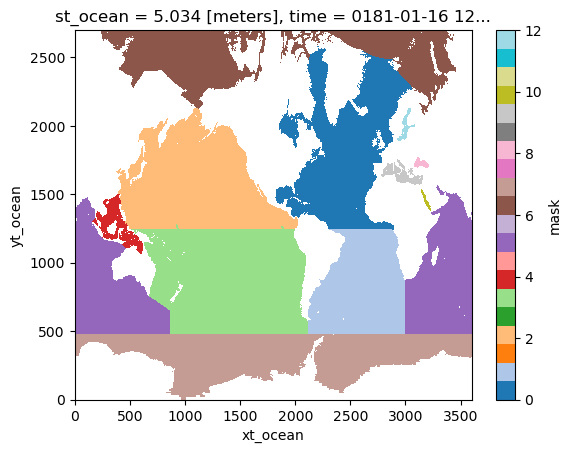

In [21]:
mask.plot(cmap='tab20');

In [13]:
#assign each region index value to basin name

north_atlantic_ocean = 0
south_atlantic_ocean = 1
north_pacific_ocean = 2
south_pacific_ocean = 3
south_china_seas = 4
indian_ocean = 5
arctic_ocean = 6
southern_ocean = 7
black_sea = 8
med_sea = 9
red_sea = 10
baltic_sea = 12 #no 11

In [14]:
def basin_selection(tend_term, basin):
    tendency_in_basin = tend_term.where(mask==basin)
    return tendency_in_basin

In [15]:
all_tendencies = list(tendencies.data_vars)

In [16]:
tend = tendencies

In [17]:
#Atlantic Ocean - going to add 'NATL' prefix after adding natl_ocean+nor_sea+lab_sea respective vars
natl_ocean = xr.merge([basin_selection(tend[var],
                                       north_atlantic_ocean).rename('NATL_' + var) for var in all_tendencies])
satl_ocean = xr.merge([basin_selection(tend[var], 
                                       south_atlantic_ocean).rename('SATL_' + var) for var in all_tendencies])

#Pacific Ocean
npac_ocean = xr.merge([basin_selection(tend[var], 
                                       north_pacific_ocean).rename('NPAC_' + var) for var in all_tendencies])
spac_ocean = xr.merge([basin_selection(tend[var], 
                                       south_pacific_ocean).rename('SPAC_' + var) for var in all_tendencies])

#Indian Ocean
ind_ocean = xr.merge([basin_selection(tend[var], indian_ocean).rename('IND_' + var) for var in all_tendencies])

#Arctic Ocean
arc_ocean = xr.merge([basin_selection(tend[var], arctic_ocean).rename('ARC_' + var) for var in all_tendencies])

#Southern Ocean
south_ocean = xr.merge([basin_selection(tend[var], 
                                        southern_ocean).rename('South_' + var) for var in all_tendencies])

In [18]:
natl_ocean

<xarray.Dataset>
Dimensions:         (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    geolat_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time            (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
    lat             (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    lon             (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    st_ocean        float64 5.034
Data variables:
    NATL_cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

### Mixing part (histograms)

In [24]:
from xhistogram.xarray import histogram
def histogram_function(ds, prefix, ocean, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(ds[prefix+variable].fillna(0.)*(weights).where(mask==ocean).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho

In [25]:
#mixing components
natl_hist = xr.merge([histogram_function(natl_ocean, 'NATL_', north_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
satl_hist = xr.merge([histogram_function(satl_ocean, 'SATL_', south_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
npac_hist = xr.merge([histogram_function(npac_ocean, 'NPAC_', north_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
spac_hist = xr.merge([histogram_function(spac_ocean, 'SPAC_', south_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
ind_hist = xr.merge([histogram_function(ind_ocean, 'IND_', indian_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
arc_hist = xr.merge([histogram_function(arc_ocean, 'ARC_', arctic_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
south_hist = xr.merge([histogram_function(south_ocean, 'South_', southern_ocean,
                                          var).rename('OMEGA_' + var) for var in all_tendencies])

In [26]:
natl_hist

<xarray.Dataset>
Dimensions:          (time: 7305, rho0_bin: 199)
Coordinates:
  * time             (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
Data variables:
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

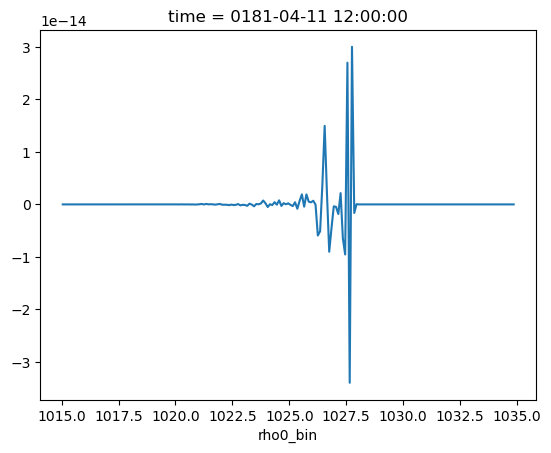

In [26]:
((natl_hist.OMEGA_rho_lap + natl_hist.OMEGA_cabbeling - natl_hist.OMEGA_sss - natl_hist.OMEGA_sst)[100]/1e6).plot()

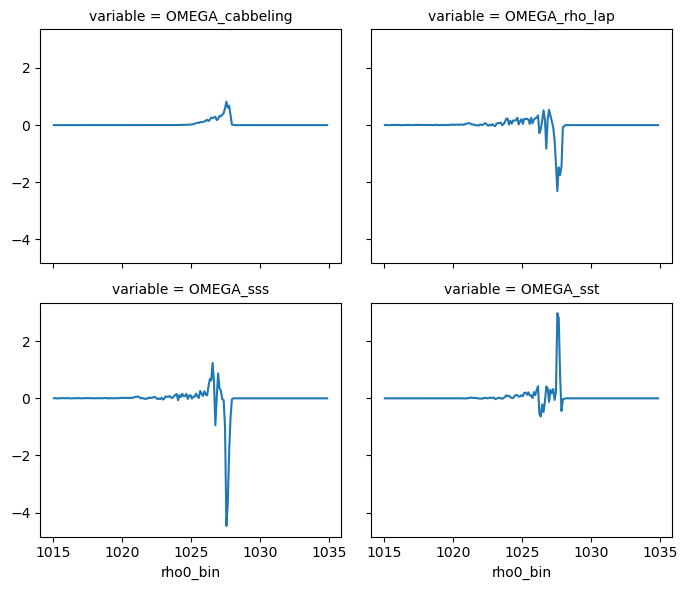

In [27]:
(natl_hist.isel(time=100)/1e6).to_array().plot(col='variable', col_wrap=2)

## 4) Save the histograms by basin

In [35]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [36]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.781075d87c3c4830b83462063752813f/status,


In [21]:
from tqdm import tqdm
import zarr

def to_zarr_split(ds, mapper, split_dim="time", split_interval=1):
    print(f"Writing to {mapper.root} ...")

    n = len(ds[split_dim])
    splits = list(range(0, n, split_interval))

    # Make sure the last item in the list covers the full length
    # of the time on our dataset
    if splits[-1] != n:
        splits = splits + [n]

    split_datasets = []
    for ii in range(len(splits) - 1):
        start = splits[ii]
        stop = splits[ii + 1]
        split_datasets.append(ds.isel({split_dim: slice(start, stop)}))

    # write the first array
    # TODO: move the first write to the loop so it is counted in the viz bar
    split_datasets[0].to_zarr(mapper)
    for ds_split in tqdm(split_datasets[1:None]):
        ds_split.to_zarr(mapper, append_dim=split_dim)

    # overwrite the split dimension as single chunk (this should reproduce
    # what xr.to_zarr would do
    g = zarr.open_group(mapper)
    del g[split_dim]
    
    ds[[split_dim]].load().to_zarr(mapper, mode='a')
    zarr.consolidate_metadata(mapper)

### Save Mixing tendency terms

In [22]:
basin_names = list(['natl_ocean','npac_ocean', 'arc_ocean', 'south_ocean', 'ind_ocean'])
ocean_ds = list([natl_ocean, npac_ocean, arc_ocean, south_ocean, ind_ocean])

In [23]:
basin_names[3:]

['south_ocean', 'ind_ocean']

In [34]:
client.close()
cluster.close()

In [34]:
ocean_ds[2]

<xarray.Dataset>
Dimensions:        (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    geolat_t       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time           (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean       (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean       (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    lat            (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    lon            (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    st_ocean       float64 5.034
Data variables:
    ARC_cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ARC_rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ARC_sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ARC_sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [41]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.b3e4284bc48645e388434cf99d641646/status,


In [31]:
arc_ocean

<xarray.Dataset>
Dimensions:        (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    geolat_t       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time           (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean       (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean       (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    lat            (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    lon            (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    st_ocean       float64 5.034
Data variables:
    ARC_cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ARC_rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ARC_sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ARC_sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [26]:
client.close()
cluster.close()

In [25]:
for (i,j) in zip(basin_names[3:], ocean_ds[3:]):
    mapper = gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/' + i + '.zarr')
    to_zarr_split(j, mapper)

Writing to pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/south_ocean.zarr ...


100%|██████████| 7304/7304 [20:29:36<00:00, 10.10s/it]   


Writing to pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/ind_ocean.zarr ...


100%|██████████| 7304/7304 [20:20:12<00:00, 10.02s/it]   


In [ ]:
gcsmap_arc = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/arc_ocean_last1223.zarr')
arc_ocean.isel(time=slice(6082, None)).to_zarr(gcsmap_arc, mode='w')

In [37]:
arc_ocean.isel(time=slice(6082, None))

<xarray.Dataset>
Dimensions:        (yt_ocean: 2700, xt_ocean: 3600, time: 1223)
Coordinates:
    geolat_t       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time           (time) object 0197-08-27 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean       (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean       (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    lat            (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    lon            (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    st_ocean       float64 5.034
Data variables:
    ARC_cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ARC_rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ARC_sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ARC_sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

### Save Mixing histogram terms

In [30]:
hist_names = list(['natl_hist', 'satl_hist', 'npac_hist', 'spac_hist', 'arc_hist', 'south_hist', 'ind_hist'])
hist_ds = list([natl_hist, satl_hist, npac_hist, spac_hist, arc_hist, south_hist, ind_hist])

In [32]:
for (i,j) in zip(hist_names, hist_ds):
    mapper = gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/outliers_rm/' + i + '.zarr')
    to_zarr_split(j, mapper)

Writing to pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/outliers_rm/natl_hist.zarr ...


 30%|██▉       | 2182/7304 [4:22:46<10:16:49,  7.23s/it]


KeyboardInterrupt: 